# Active Perception for Focused Transmit Steering

In this tutorial we will implement a basic perception-action loop to drive intelligent and adaptive focused transmit steering. We will use [Diffusion Models](http://127.0.0.1:8000/_autosummary/zea.models.diffusion.html#zea.models.diffusion.DiffusionModel) to implement perception-as-inference, with [greedy entropy minimization](http://127.0.0.1:8000/_autosummary/zea.agent.selection.html#zea.agent.selection.GreedyEntropy) as our action selection policy.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/agent/agent_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/agent/agent_example.ipynb)
&nbsp;
[![Hugging Face model](https://img.shields.io/badge/Hugging%20Face-Model-yellow?logo=huggingface)](https://huggingface.co/zeahub/diffusion-echonet-dynamic)

In [1]:
%%capture
%pip install zea

In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
import keras
import keras.ops as ops
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from tqdm import tqdm

from zea import init_device
from zea.models.diffusion import DiffusionModel
from zea.ops import Pipeline, ScanConvert
from zea.data import Dataset
from zea.visualize import plot_image_grid, set_mpl_style
from zea.agent.selection import GreedyEntropy
from zea.utils import translate

zea: Using backend 'jax'


In [4]:
n_prior_samples = 4
unconditional_steps = 90
initial_conditonal_steps = 180
conditional_steps = 200
n_conditional_samples = 4

We will work with the GPU if available, and initialize using `init_device` to pick the best available device. Also, (optionally), we will set the matplotlib style for plotting.

In [5]:
init_device(verbose=False)
set_mpl_style()

## Load dataset and model

In [6]:
# load generative model
model = DiffusionModel.from_preset("diffusion-echonet-dynamic")
img_shape = model.input_shape[:2]


# load camus dataset
dataset = Dataset("hf://zeahub/camus-sample/val", key="image")
data = dataset[0]["data"]["image"]
data = keras.ops.expand_dims(data, axis=-1)
data = keras.ops.image.resize(data, img_shape)
dynamic_range = (-40, 0)
data = keras.ops.clip(data, dynamic_range[0], dynamic_range[1])
data = translate(data, dynamic_range, (-1, 1))
data = data[..., 0]  # remove channel dim

zea: Using pregenerated dataset info file: /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/dataset_info.yaml ...
zea: ...for reading file paths in /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val
zea: Dataset was validated on July 17, 2025
zea: Remove /home/devcontainer15/.cache/zea/huggingface/datasets/datasets--zeahub--camus-sample/snapshots/617cf91a1267b5ffbcfafe9bebf0813c7cee8493/val/validated.flag if you want to redo validation.


## Visualize target sequence
Here we load a sequence of ultrasound frames from the CAMUS validation set. This will be our 'ground truth' target sequence, that the agent will need to reconstruct from a small budget of focused scan lines

zea: WARNING GPU support for order > 1 is not available. Disabling jit for ScanConvert.


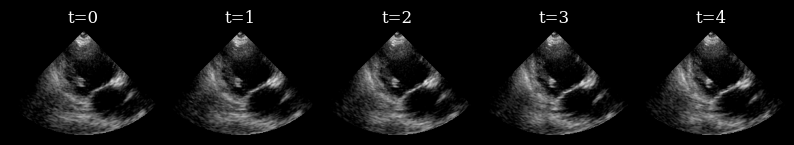

In [7]:
scan_convert = Pipeline([ScanConvert(order=2, jit_compile=False)])
parameters = {
    "theta_range": [-0.78, 0.78],  # [-45, 45] in radians
    "rho_range": [0, 1],
}
parameters = scan_convert.prepare_parameters(**parameters)
data_sc = scan_convert(data=data, **parameters)["data"]

n_frames_to_plot = 5
fig, _ = plot_image_grid(
    data_sc[:n_frames_to_plot],
    titles=[f"t={t}" for t in range(n_frames_to_plot)],
    ncols=n_frames_to_plot,
    remove_axis=True,
    vmin=-1,
    vmax=1,
)

## Simulate Focused Line Acquisition
We use a simple masking operator to simulate acquiring a set of focused lines from the tissue, where each line reveals a vertical column of pixels, in the polar domain, of the target.

In [8]:
def simulate_acquisition(full_frame, mask):
    measurement = full_frame[None, ...] * mask
    return measurement, mask

### Perception-Action Loop

Initially, we have not yet acquired any measurements, so we draw samples from the prior to drive our actions.

90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step


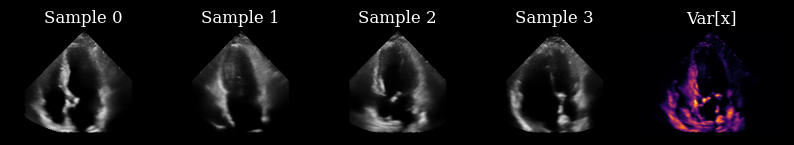

In [9]:
prior_samples = model.sample(n_samples=n_prior_samples, n_steps=unconditional_steps, verbose=True)
scan_converted_prior_samples = scan_convert(
    data=keras.ops.squeeze(prior_samples, axis=-1), **parameters
)["data"]
posterior_variance = ops.nan_to_num(ops.var(scan_converted_prior_samples, axis=0))
fig, _ = plot_image_grid(
    list(scan_converted_prior_samples) + [translate(posterior_variance, range_to=(-1, 1))],
    titles=[f"Sample {i}" for i in range(n_prior_samples)] + ["Var[x]"],
    vmin=-1,
    vmax=1,
    cmap=["gray"] * n_prior_samples + ["inferno"],
)

Next, we implement a perception-action loop, using a greedy entropy minimization strategy to select which lines to acquire next in the sequence. Each set of generated posterior samples at time $t$ are used as _initial samples_ for the reverse diffusion at time $t+1$ [1], ensuring that we generate a reconstructed sequence that is coherent over time.

[1] https://ieeexplore.ieee.org/document/10889752

In [10]:
frame_height, frame_width, _ = model.input_shape
action_selector = GreedyEntropy(
    n_actions=14,  # acquire 25% of measurements
    n_possible_actions=frame_width,
    img_width=frame_width,
    img_height=frame_height,
)

# select the first actions based on the prior samples
prior_samples_batched = prior_samples[None, ..., 0]  # add batch, remove channel
selected_lines, measurement_mask = action_selector.sample(prior_samples_batched)
# initialise the previous samples as the prior samples
previous_samples = prior_samples

reconstructions = []
measurements = []
for target_frame in tqdm(data):
    # perception
    measurements_t, measurement_mask_t = simulate_acquisition(target_frame, measurement_mask)
    posterior_samples = model.posterior_sample(
        measurements=measurements_t[..., None],  # add channel dim
        mask=measurement_mask_t[..., None],  # add channel dim
        initial_samples=previous_samples,
        n_samples=n_conditional_samples,
        n_steps=conditional_steps,
        omega=10,
        initial_step=initial_conditonal_steps,
    )

    # action
    selected_lines, measurement_mask = action_selector.sample(posterior_samples[..., 0])

    # gather the selected measurements and reconstructions for visualization
    reconstructions.append(posterior_samples[0])
    measurements.append(measurements_t)
    # reset the previous_samples
    previous_samples = posterior_samples

100%|██████████| 17/17 [00:13<00:00,  1.23it/s]


In [11]:
# postprocess outputs for plotting
reconstructions = ops.convert_to_tensor(reconstructions)
measurements = ops.convert_to_tensor(measurements)
selected_reconstructions = reconstructions[
    :, 0, ...
]  # choose first sample for each frame to display
reconstructions_sc = scan_convert(data=selected_reconstructions[..., 0], **parameters)["data"]
measurements_sc = scan_convert(data=measurements[:, 0, ...], **parameters)["data"]
variances_sc = scan_convert(
    data=ops.var(reconstructions, axis=1)[..., 0], **(parameters | {"fill_value": 0.0})
)["data"]
variances_sc = translate(variances_sc, range_to=(-1, 1))

## Visualize the results
Finally, we visualize our reconstructed sequence, along with the selected measurements and posterior variance at each step. The agent's goal of minizing posterior entropy is reflected in the low posterior variance throughout the sequence. You can see that the agent is quickly able to reduce the uncertainty after the first frame, when it was able to observe using acquisition of the first focused lines.

In [12]:
# plot image
fig, ims = plot_image_grid(
    [data_sc[0], measurements_sc[0], reconstructions_sc[0], variances_sc[0]],
    titles=["Target", "Measurements", "Reconstruction", "Variance"],
    ncols=4,
    vmin=-1,
    vmax=1,
    cmap=["gray"] * 3 + ["inferno"],
    figsize=(11, 4),
)


def update(frame):
    ims[0].set_array(data_sc[frame])
    ims[1].set_array(measurements_sc[frame])
    ims[2].set_array(reconstructions_sc[frame])
    ims[3].set_array(variances_sc[frame])

    return ims


ani = animation.FuncAnimation(fig, update, frames=len(data_sc), blit=True, interval=100)
plt.close(fig)
HTML(ani.to_jshtml())